importing necessary 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

Create a Dataframe 'movie_gross_df' from the bom.movie_gross.csv.gz file in the zippedData folder

In [24]:
movie_gross_df=pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_df.head(10)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


Create a Dataframe from the IMDB file in the zippedData folder

Write a query to join the movie_basics and movie_ratings tables.  We want to see all movies with atleast 5000 votes(popular movies) and rating above 7(high quality movies).  

rating_df is the DataFrame

In [68]:
conn = sqlite3.connect('im.db')
cur = conn.cursor()
q= """SELECT 
             primary_title as Title,
             start_year as Year,
             genres as Genre,
             averagerating as Rating,
             numvotes as Votes
        FROM movie_basics
        JOIN movie_ratings
             USING(movie_id)
       
       WHERE votes > 5000 AND rating >= 7    
       ORDER BY rating DESC
            
                 ;"""
rating_df = pd.read_sql(q,conn)
rating_df.head()

    

,Title,Year,Genre,Rating,Votes
0,Once Upon a Time ... in Hollywood,2019,"Comedy,Drama",9.7,5600
1,Aloko Udapadi,2017,"Drama,History",9.5,6509
2,Peranbu,2018,Drama,9.4,9629
3,The Mountain II,2016,"Action,Drama,War",9.3,100568
4,Aynabaji,2016,"Crime,Mystery,Thriller",9.3,18470


Explore / clean up the genres column.  Look at the counts and determine which sub categories (new columns) need to be created.  Multi-Genre(boolean) would be a good start.

In [72]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   1322 non-null   object 
 1   Year    1322 non-null   int64  
 2   Genre   1322 non-null   object 
 3   Rating  1322 non-null   float64
 4   Votes   1322 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 51.8+ KB


Fortunately, there are no missing values in this subgroup.

In [76]:
rating_df.Genre.value_counts()

Drama                      109
Comedy,Drama                81
Drama,Romance               54
Documentary                 46
Comedy,Drama,Romance        46
                          ... 
Crime,Drama,War              1
Drama,History,Musical        1
Adventure,Comedy,Sci-Fi      1
Action,Documentary           1
Documentary,Drama,News       1
Name: Genre, Length: 231, dtype: int64

Add a Multi-Genre column and fill with boolean values.  True if ',' exists.  False if only one category

In [79]:
example = ',' in rating_df['Genre'][0]
example

True

Now try for all of them... lambda function opportunity...

In [80]:
rating_df['Multi-Genre'] = rating_df['Genre'].map(lambda x: ',' in x)
rating_df.head()

,Title,Year,Genre,Rating,Votes,Multi-Genre
0,Once Upon a Time ... in Hollywood,2019,"Comedy,Drama",9.7,5600,True
1,Aloko Udapadi,2017,"Drama,History",9.5,6509,True
2,Peranbu,2018,Drama,9.4,9629,False
3,The Mountain II,2016,"Action,Drama,War",9.3,100568,True
4,Aynabaji,2016,"Crime,Mystery,Thriller",9.3,18470,True


Create a subset data frame to get the most common genres from the multi-genre movies.  We will use these later to create more boolean columns in rating_df.

In [84]:
multi_df = rating_df[rating_df['Multi-Genre']==True]
multi_df

,Title,Year,Genre,Rating,Votes,Multi-Genre
0,Once Upon a Time ... in Hollywood,2019,"Comedy,Drama",9.7,5600,True
1,Aloko Udapadi,2017,"Drama,History",9.5,6509,True
3,The Mountain II,2016,"Action,Drama,War",9.3,100568,True
4,Aynabaji,2016,"Crime,Mystery,Thriller",9.3,18470,True
6,CM101MMXI Fundamentals,2013,"Comedy,Documentary",9.2,41560,True
...,...,...,...,...,...,...
1317,The Silence,2010,"Crime,Drama,Thriller",7.0,5792,True
1318,Raw,2016,"Drama,Horror",7.0,49570,True
1319,Game Night,2018,"Action,Comedy,Crime",7.0,163279,True
1320,Crimea,2017,"Action,Drama",7.0,32800,True


create a list of genres.  Need to go through each row and split on the commas.  Then check to see if those items are already in the list before adding them.  

In [101]:
#list to hold the genres
genre_list = []
#function to get all the genres separated and added to the list
def get_genre(row):
    words = row.split(',')
    for w in words:
        if w not in genre_list:
            genre_list.append(w)

#lambda function to get the entire dataframe
multi_df['Genre'].map(lambda x: get_genre(x))
genre_list


['Comedy',
 'Drama',
 'History',
 'Action',
 'War',
 'Crime',
 'Mystery',
 'Thriller',
 'Documentary',
 'Biography',
 'Music',
 'Musical',
 'Romance',
 'Adventure',
 'Sci-Fi',
 'Sport',
 'Animation',
 'Western',
 'Fantasy',
 'Horror',
 'Family',
 'News']

Adding columns to rating_df for each category and entering the boolean value

In [103]:
# loop through genre_list and create a new column and then check if 
#that genre is listed in the main genre category
subgenre_df = rating_df.copy(deep=True)
for g in genre_list:
    subgenre_df[g] = subgenre_df['Genre'].map(lambda x: g in x)
subgenre_df    


,Title,Year,Genre,Rating,Votes,Multi-Genre,Comedy,Drama,History,Action,...,Romance,Adventure,Sci-Fi,Sport,Animation,Western,Fantasy,Horror,Family,News
0,Once Upon a Time ... in Hollywood,2019,"Comedy,Drama",9.7,5600,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Aloko Udapadi,2017,"Drama,History",9.5,6509,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,Peranbu,2018,Drama,9.4,9629,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,The Mountain II,2016,"Action,Drama,War",9.3,100568,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,Aynabaji,2016,"Crime,Mystery,Thriller",9.3,18470,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,The Silence,2010,"Crime,Drama,Thriller",7.0,5792,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1318,Raw,2016,"Drama,Horror",7.0,49570,True,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1319,Game Night,2018,"Action,Comedy,Crime",7.0,163279,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1320,Crimea,2017,"Action,Drama",7.0,32800,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


get counts for each of the columns

In [110]:
#use the genre_list to find the counts of each group
#creating key,value pairs for dictionary of sums
genre_count_dict ={}
for g in genre_list:
    genre_count_dict[g] = subgenre_df[g].sum()
genre_count_dict

{'Comedy': 351,
 'Drama': 893,
 'History': 91,
 'Action': 277,
 'War': 38,
 'Crime': 216,
 'Mystery': 94,
 'Thriller': 183,
 'Documentary': 140,
 'Biography': 193,
 'Music': 57,
 'Musical': 10,
 'Romance': 169,
 'Adventure': 194,
 'Sci-Fi': 65,
 'Sport': 40,
 'Animation': 92,
 'Western': 7,
 'Fantasy': 58,
 'Horror': 36,
 'Family': 38,
 'News': 5}

Create a bar graph from the 'genre_count_dict'

Text(0.5, 1.0, 'Genre Frequency in Top Rated Movies')

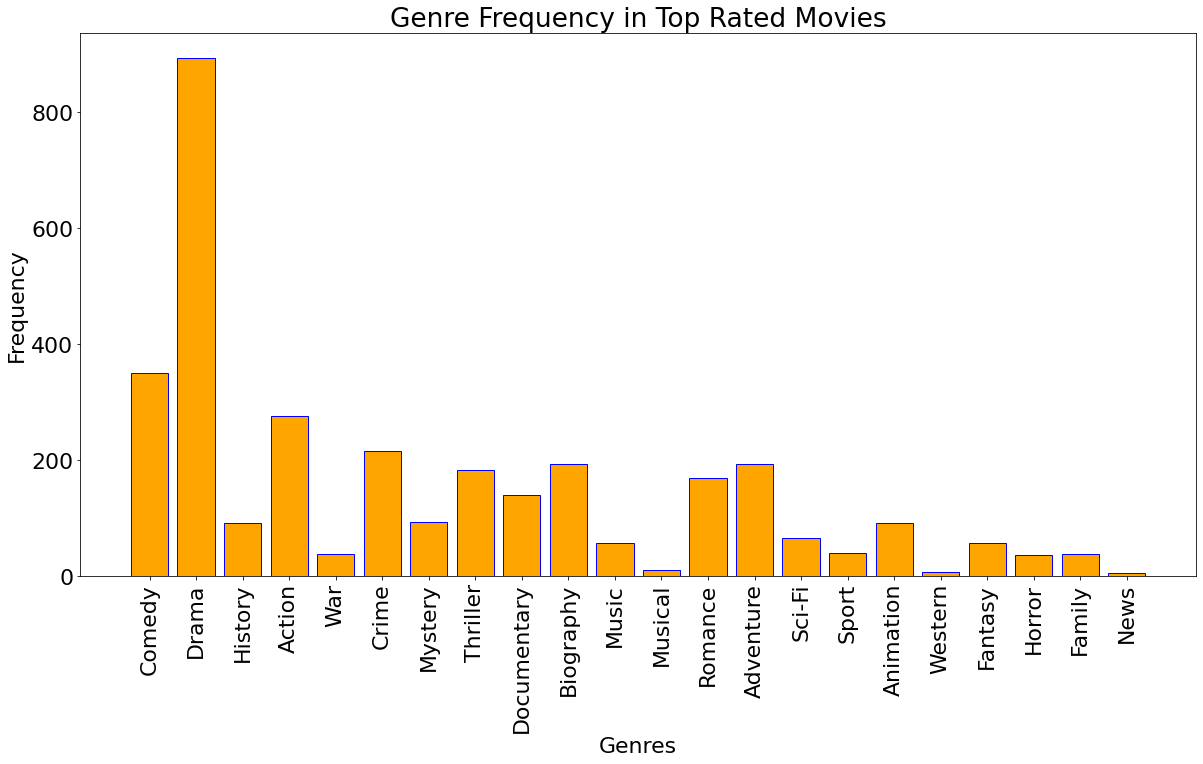

In [142]:
# Plotting the genre frequency in a bar chart
plt.figure(figsize=(20,10))
#create variables for x and y values
x_val = list(genre_count_dict.keys())
y_val = genre_count_dict.values()
#plotting the bar chart
plt.bar(x_val,y_val, color='orange', edgecolor='b')
#make the bar chart look nicer
plt.rc('font', size = 22)
plt.rc('axes', labelsize=12)
plt.xticks(rotation=90)
plt.ylabel('Frequency',size=22)
plt.xlabel('Genres', size=22)
plt.title("Genre Frequency in Top Rated Movies")

It looks like almost 70% of the movies are categorized as some sort of Drama.  I suspect that this is a generic term and that there are very few movies just listed.  

We will want to go back and look at ratings by genre

Now let's find the average rating of movies that classify in each of these categories. 

Creating a new query to get a df with all of the movies. Copy from above

In [206]:
q= """SELECT 
             primary_title as Title,
             start_year as Year,
             genres as Genre,
             averagerating as Rating,
             numvotes as Votes
        FROM movie_basics
        JOIN movie_ratings
             USING(movie_id)
       
            
                 ;"""
all_df = pd.read_sql(q,conn)
all_df

,Title,Year,Genre,Rating,Votes
0,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,One Day Before the Rainy Season,2019,"Biography,Drama",7.2,43
2,The Other Side of the Wind,2018,Drama,6.9,4517
3,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...
73851,Diabolik sono io,2019,Documentary,6.2,6
73852,Sokagin Çocuklari,2019,"Drama,Family",8.7,136
73853,Albatross,2017,Documentary,8.5,8
73854,La vida sense la Sara Amat,2019,None,6.6,5


    Clean up the all_df to change None to 'no genre'
    This will make it possible to use the same code from above to create sub genre columns, which we will need to find the average ratings for each sub category.

In [209]:
#How many of these movies do not have a genre
all_df['Genre'].isna().value_counts()  

#looks like None is entered -- we can change those to 'no genre'
all_df['Genre'] = all_df['Genre'].map(lambda x: 'no genre' if x == None else x)



        

In [210]:
all_df

,Title,Year,Genre,Rating,Votes
0,Sunghursh,2013,"Action,Crime,Drama",7.0,77
1,One Day Before the Rainy Season,2019,"Biography,Drama",7.2,43
2,The Other Side of the Wind,2018,Drama,6.9,4517
3,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13
4,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...
73851,Diabolik sono io,2019,Documentary,6.2,6
73852,Sokagin Çocuklari,2019,"Drama,Family",8.7,136
73853,Albatross,2017,Documentary,8.5,8
73854,La vida sense la Sara Amat,2019,no genre,6.6,5


use the subgenre code from above on the all_df

In [212]:
for g in genre_list:
    all_df[g] = all_df['Genre'].map(lambda x: g in x)
all_df 

,Title,Year,Genre,Rating,Votes,Comedy,Drama,History,Action,War,...,Romance,Adventure,Sci-Fi,Sport,Animation,Western,Fantasy,Horror,Family,News
0,Sunghursh,2013,"Action,Crime,Drama",7.0,77,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,One Day Before the Rainy Season,2019,"Biography,Drama",7.2,43,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,The Other Side of the Wind,2018,Drama,6.9,4517,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Sabse Bada Sukh,2018,"Comedy,Drama",6.1,13,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.5,119,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73851,Diabolik sono io,2019,Documentary,6.2,6,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73852,Sokagin Çocuklari,2019,"Drama,Family",8.7,136,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
73853,Albatross,2017,Documentary,8.5,8,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73854,La vida sense la Sara Amat,2019,no genre,6.6,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
